In [1]:
##Opening Data And saving

# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

!ls '/content/drive/My Drive/Colab Notebooks/Projecte final/vehicle-detection-master/'
myDrive = '/content/drive/My Drive/Colab Notebooks/Projecte final/vehicle-detection-master/'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive
car_features.pkl      output		 README.md		 result.mp4
main.ipynb	      OwnCollection	 requirements.txt	 test_images
not_car_features.pkl  project_video.mp4  Resultat_VideoTest.mp4  VideoTest.mp4


In [0]:
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
import time
from sklearn.model_selection import train_test_split, RandomizedSearchCV

import sklearn.svm as svm
import numpy as np
import matplotlib.image as mpimg
import cv2
import glob

from sklearn.externals import joblib
from scipy.ndimage.measurements import label
import pickle

import matplotlib.pyplot as plt
import matplotlib.cm as cm 
%matplotlib inline


import keras # broken for keras >= 2.0, use 1.2.2
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.optimizers import SGD
from keras.utils import plot_model

In [0]:
# Get image file names
images = glob.glob(myDrive+'./OwnCollection/*/*/*.png')
cars = []
notcars = []
all_cars = []
all_notcars = []


for image in images:
    if 'non-vehicle' in image:
        all_notcars.append(image)
    else:
        all_cars.append(image)

# Get only 1/5 of the training data to avoid overfitting
for ix, notcar in enumerate(all_notcars):
    if ix % 5 == 0:
        notcars.append(notcar)
        
for ix, car in enumerate(all_cars):
    if ix % 5 == 0:
        cars.append(car)   

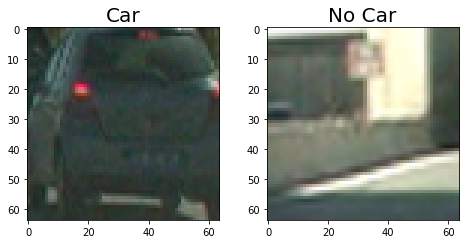

In [0]:
car_image = mpimg.imread(cars[100])
notcar_image = mpimg.imread(notcars[50])

def compare_images(image1, image2, image1_exp="Image 1", image2_exp="Image 2"):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(6, 3))
    f.tight_layout()
    ax1.imshow(image1)
    ax1.set_title(image1_exp, fontsize=20)
    ax2.imshow(image2)
    ax2.set_title(image2_exp, fontsize=20)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
        
compare_images(car_image, notcar_image, "Car", "No Car")

In [0]:
def get_spatialbin_features(img, params):
    assert np.max(img) <= 1.
    features = cv2.resize(img, params["dstsize"]).ravel() 
    return features

def get_colorhist_features(img, params):
    assert np.max(img) <= 1.
    temp_img = (img * 255).astype(np.uint8)
    saturation = cv2.cvtColor(temp_img, cv2.COLOR_RGB2HLS)
    saturation_hist = np.histogram(saturation[:,:,2].ravel(), bins=params["nbins"], range=params["bins_range"])
    return saturation_hist[0]


def get_hog_features(img, params):
    """
    Extract features from the image based on Histogram of Gradients
    :param img: RGB Image from which the features are to be extracted
    :param hog_params: Parameters for extracting features using histogram of oriented gradients, in dictionary
    :return: HoG features for the image as described by the parameters
    :rtype: Numpy 1-D array
    
    hog(image, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(3, 3), block_norm=None,\
    visualize=False, visualize=None, transform_sqrt=False, feature_vector=True, multichannel=None)
    """
    if params["multichannel"] == False or img.ndim < 3:
        if img.ndim == 3:
            intermediate = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)[:,:,0]
        else:
            intermediate = img
        result = hog(intermediate,\
                    orientations = params["orientations"],\
                    pixels_per_cell = params["pixels_per_cell"],\
                    transform_sqrt = params["transform_sqrt"],\
                    cells_per_block = params["cells_per_block"],\
                    block_norm = params["block_norm"],\
                    visualize = params["visualize"],
                    feature_vector = params["feature_vector"])

        return result
    else:
        temp_img = np.uint8(img * 255)
        img = cv2.cvtColor(temp_img, cv2.COLOR_RGB2YCrCb)
        hog_features = []
        vis = np.zeros_like(img[:,:,1], dtype='uint8')
        for channel in range(img.shape[2]):
            result = hog(img[:,:,channel],\
                        orientations = params["orientations"],\
                        pixels_per_cell = params["pixels_per_cell"],\
                        transform_sqrt = params["transform_sqrt"],\
                        cells_per_block = params["cells_per_block"],\
                        block_norm = params["block_norm"],\
                        visualize = params["visualize"],
                        feature_vector = params["feature_vector"])
            if params["visualize"]:
                hog_features.append(result[0])
                scaled = np.array(result[1] * 255, dtype='uint8')
                if np.max(vis) == 0:
                    vis = scaled
                else:
                    vis = cv2.addWeighted(vis, 0.5, scaled, 0.5, 0)
            else:
                hog_features.append(result)
        if params["visualize"]:
            return np.concatenate(hog_features), vis
        return np.concatenate(hog_features)
    

## Parameters definition for testing

In [0]:
hog_params = {
    'orientations' : 11,
    'pixels_per_cell' : (14, 14),
    'cells_per_block':(2, 2),
    'block_norm':'L2',
    'visualize': False,
    'transform_sqrt': True,
    'feature_vector': True,
    'multichannel': True
}

spatial_bin_params = {
    'dstsize' : (32,32)
}

color_hist_params = {
    'nbins' : 16,
    'bins_range' : (0,1),
}

## Histogram of Oriented Gradients

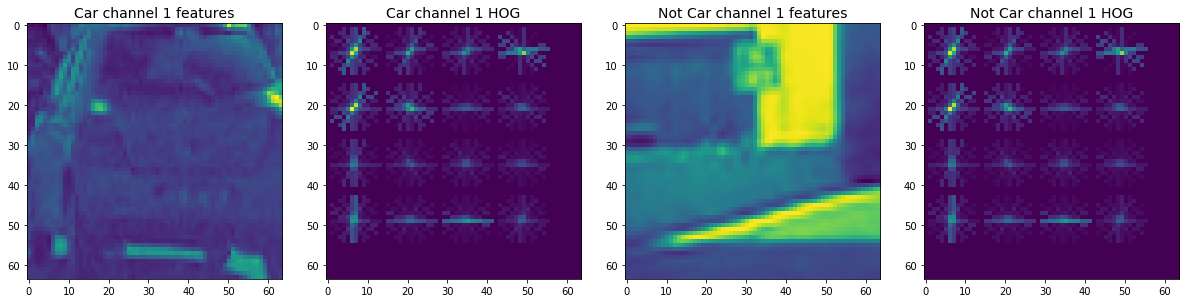

In [0]:
def show_images(image1, image2, image3, image4,  image1_exp="Image 1", image2_exp="Image 2", image3_exp="Image 3", image4_exp="Image 4"):
    f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(16, 9))
    f.tight_layout()
    ax1.imshow(image1)
    ax1.set_title(image1_exp, fontsize=14)
    ax2.imshow(image2)
    ax2.set_title(image2_exp, fontsize=14)
    ax3.imshow(image3)
    ax3.set_title(image3_exp, fontsize=14)
    ax4.imshow(image4)
    ax4.set_title(image4_exp, fontsize=14)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

    

converted_car_image = cv2.cvtColor(car_image, cv2.COLOR_RGB2YUV)
car_ch1 = converted_car_image[:,:,0]
car_ch2 = converted_car_image[:,:,1]
car_ch3 = converted_car_image[:,:,2]

converted_notcar_image = cv2.cvtColor(notcar_image, cv2.COLOR_RGB2YUV)
notcar_ch1 = converted_notcar_image[:,:,0]
notcar_ch2 = converted_notcar_image[:,:,1]
notcar_ch3 = converted_notcar_image[:,:,2]

car_hog_feature= get_hog_features(car_ch1, hog_params)
hog_params2 = hog_params.copy()
hog_params2["visualize"] = True
features, vis = get_hog_features(car_ch1, hog_params2)


notcar_hog_feature= get_hog_features(notcar_ch1,hog_params)
car_hog_feature= get_hog_features(car_ch1, hog_params)
hog_params2 = hog_params.copy()
hog_params2["visualize"] = True
features, vis2 = get_hog_features(car_ch1, hog_params2)


spatial_size = (32, 32) # Spatial binning dimensions
car_ch1_features = cv2.resize(car_ch1, spatial_size)
notcar_ch1_features = cv2.resize(notcar_ch1, spatial_size)

show_images(car_ch1, vis, notcar_ch1, vis2, "Car channel 1 features", "Car channel 1 HOG", "Not Car channel 1 features", "Not Car channel 1 HOG")  
    
  
  
#img=mpimg.imread(cars[100])
#hog_params2 = hog_params.copy()
#hog_params2["visualize"] = True
#features, vis = get_hog_features(img, hog_params2)

#plt.imshow(vis)

In [0]:
def get_single_img_feature(img, hog_params = None, spatial_bin_params = None, color_hist_params = None):
    """
    This function extracts features for a single image.
    """
    assert hog_params is not None or\
        spatial_bin_params is not None or\
        color_hist_params is not None,\
        "Must pass at least one feature extraction technique parameters"
    
    combined_features = []
    
    if spatial_bin_params is not None:
        spatial_bin_features = get_spatialbin_features(img, spatial_bin_params)
        combined_features.append(spatial_bin_features.ravel())
        
    if color_hist_params is not None:
        color_hist_features = get_colorhist_features(img, color_hist_params)
        combined_features.append(color_hist_features.ravel())
        
    if hog_params is not None:
        hog_features = get_hog_features(img, hog_params)
        combined_features.append(hog_features.ravel())
    
    return np.concatenate(combined_features)

def extract_features(img_paths, hog_params = None, spatial_bin_params = None, color_hist_params = None):
    """
    This function generates feature vectors from the image.
    :param img: Image in RGB color space
    :param hog_params: Parameters for extracting features using histogram of oriented gradients, in dictionary
    :param spatial_bin_params: Parameters for extracting features using spatial binning, in dictionary
    :param color_hist_params: Parameters for extracting features using color histograms, in dictionary
    :return: Feature vector for the image
    :rtype: 
    """
    features = []
    for img_path in img_paths:
        image = mpimg.imread(img_path)
        features.append(get_single_img_feature(image, hog_params, spatial_bin_params, color_hist_params))
    return features

In [0]:
car_features = extract_features(cars, hog_params, spatial_bin_params, color_hist_params)
not_car_features = extract_features(notcars, hog_params, spatial_bin_params, color_hist_params)

In [0]:
#WRITING

with open(myDrive+"car_features.pkl", "wb") as file_obj:
    pickle.dump(car_features, file_obj, protocol=pickle.HIGHEST_PROTOCOL)

with open(myDrive+"not_car_features.pkl", "wb") as file_obj:
    pickle.dump(not_car_features, file_obj, protocol=pickle.HIGHEST_PROTOCOL)

In [0]:
X = np.vstack((car_features, not_car_features)).astype(np.float64)
y = np.hstack((np.ones(len(car_features)),
              np.zeros(len(not_car_features))))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=1)

X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.15, random_state=1)

X_scaler = StandardScaler().fit(X_train)

X_train = X_scaler.transform(X_train)
X_valid = X_scaler.transform(X_valid)
X_test = X_scaler.transform(X_test)

# Training a classifier

### Deep neural networks

In [0]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, InputLayer
from keras import backend as K

In [0]:
batch_size = 16
num_classes = 2
epochs = 10

y_train_keras = keras.utils.to_categorical(y_train, num_classes)
y_valid_keras = keras.utils.to_categorical(y_valid, num_classes)
y_test_keras = keras.utils.to_categorical(y_test, num_classes)

In [0]:
model = Sequential()
model.add(InputLayer(input_shape=(X_train.shape[1],)))
model.add(Dense(100, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(18, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(24, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

In [0]:
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_13 (Dense)             (None, 100)               427700    
_________________________________________________________________
dropout_10 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_14 (Dense)             (None, 18)                1818      
_________________________________________________________________
dropout_11 (Dropout)         (None, 18)                0         
_________________________________________________________________
dense_15 (Dense)             (None, 24)                456       
_________________________________________________________________
dropout_12 (Dropout)         (None, 24)                0         
_________________________________________________________________
dense_16 (Dense)             (None, 2)                 50        
Total para

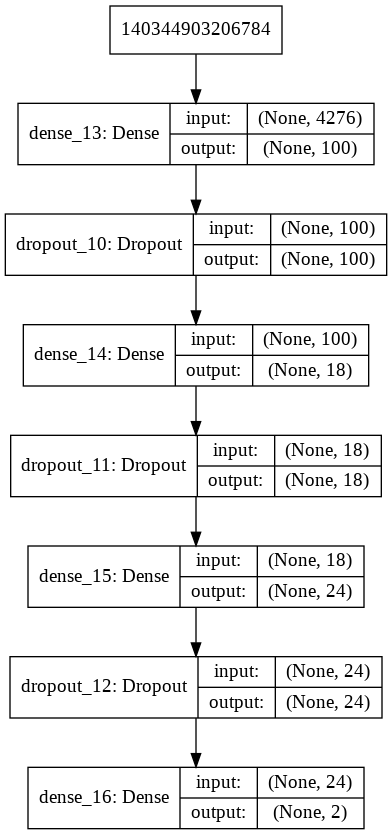

In [0]:
plot_model(model, show_shapes=True, show_layer_names=True, to_file='model.png')
from IPython.display import Image
Image(retina=True, filename='model.png')

In [0]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(X_train, y_train_keras, batch_size, epochs, validation_data=(X_valid, y_valid_keras))


Train on 1058 samples, validate on 187 samples
Epoch 1/10
1058/1058 [==============================] - 1s 1ms/step - loss: 0.8826 - acc: 0.6824 - val_loss: 0.3711 - val_acc: 0.8182
Epoch 2/10
1058/1058 [==============================] - 1s 505us/step - loss: 0.5379 - acc: 0.7836 - val_loss: 0.2675 - val_acc: 0.8824
Epoch 3/10
1058/1058 [==============================] - 1s 529us/step - loss: 0.4507 - acc: 0.8261 - val_loss: 0.1697 - val_acc: 0.9465
Epoch 4/10
1058/1058 [==============================] - 1s 497us/step - loss: 0.4155 - acc: 0.8620 - val_loss: 0.1834 - val_acc: 0.9251
Epoch 5/10
1058/1058 [==============================] - 1s 484us/step - loss: 0.3284 - acc: 0.8601 - val_loss: 0.1589 - val_acc: 0.9519
Epoch 6/10
1058/1058 [==============================] - 1s 503us/step - loss: 0.2886 - acc: 0.8960 - val_loss: 0.1205 - val_acc: 0.9519
Epoch 7/10
1058/1058 [==============================] - 1s 513us/step - loss: 0.2143 - acc: 0.9197 - val_loss: 0.0820 - val_acc: 0.9733
Epo

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


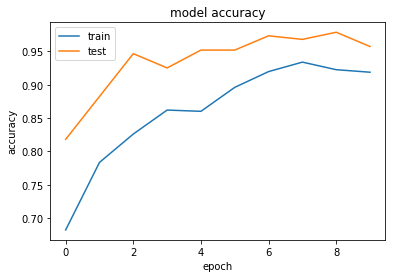

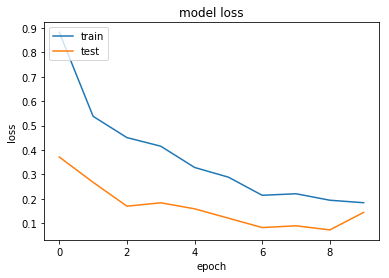

In [0]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [0]:
print("Deep Neural Network")
print(model.evaluate(X_test, y_test_keras)[1])

Deep Neural Network
220/220 [==============================] - 0s 110us/step
0.9409090898253701


---
# Sliding Window Search

In [0]:
def slide_window(img, regions):
    """
    Takes in an array of regions and returns the windows
    :param regions: An array of Region instances
    """
    # Initialize a list to append window positions to
    window_list = []
    
    for region in regions:
        xstart = region.xstart
        xstop = region.xstop
        ystart = region.ystart
        ystop = region.ystop
        xy_step = region.cells_per_step
        scan_scale_list = region.scales

        for scale in scan_scale_list:
            x_window_size = scale * 64
            y_window_size = scale * 64

            xstep = xy_step * hog_params["pixels_per_cell"][0]
            ystep = xy_step * hog_params["pixels_per_cell"][1]

            for i in range(ystart, ystop, ystep):
                for j in range(xstart, xstop, xstep):
                    startx = j
                    stopx = j + xstep
                    if stopx >= img.shape[1]:
                        stopx = img.shape[1]

                    starty = i
                    stopy = i + ystep
                    if stopy >= img.shape[0]:
                        stopy = img.shape[0]
                    window_list.append(((startx, starty), (stopx, stopy)))
    
    return window_list

In [0]:
def draw_boxes(img, bboxes, color=(0, 255, 0), alternate_color=(255,0,0),thick=4):
    imcopy = np.copy(img)
    if np.max(imcopy) <= 1.:
        imcopy = np.uint8(imcopy * 255)
    for index, bbox in enumerate(bboxes):
        if index % 2 == 0:
            cv2.rectangle(imcopy, bbox[0], bbox[1], color, 2)
        else:
            cv2.rectangle(imcopy, bbox[0], bbox[1], alternate_color, thick)
    return imcopy

## Removing false positives and aggregating boxes

In [0]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return np.clip(heatmap, 0, 255)

def draw_labeled_bboxes(img, labels, get_coordinates=False):
    duplicate = np.copy(img)
    windows = []
    if type(np.max(img)) is np.float64 or type(np.max(img)) is np.float32:
        duplicate = np.uint8(img * 255)

    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(duplicate, bbox[0], bbox[1], (0,0,255), 8)
        windows.append(((bbox[0]), (bbox[1])))
    # Return the image
    if get_coordinates:
        return duplicate, windows
    return duplicate


## Reusing HoG in sliding window search to optimize performance

In [0]:
   
def find_cars(img_, regions, X_scaler, hog_params, spatial_bin_params, color_hist_params, model, is_keras_model):
    """
    Detect cars in the image and return the positive windows
    """
    img = np.copy(img_).astype(np.float32)
    
    # Initialize list to store positive window coordinates
    positive_windows = []

    for region in regions:
        xstart = region.xstart
        xstop = region.xstop
        ystart = region.ystart
        ystop = region.ystop
        cells_per_step = region.cells_per_step
        scan_scale_list = region.scales
        
        img_cropped = img[ystart:ystop,xstart:xstop,:]
        imshape = img_cropped.shape
        
        for scale in scan_scale_list:
            if scale != 1:
                img_tosearch = cv2.resize(img_cropped, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
            else:
                img_tosearch = np.copy(img_cropped)

            img_to_search_scaled = np.uint8(img_tosearch * 255)
            ycrcb_img = cv2.cvtColor(img_to_search_scaled, cv2.COLOR_RGB2YCrCb)

            ch1 = ycrcb_img[:,:,0]
            ch2 = ycrcb_img[:,:,1]
            ch3 = ycrcb_img[:,:,2]

            # Define blocks and steps as above
            nxblocks = (ch1.shape[1] // hog_params["pixels_per_cell"][0]) - hog_params["cells_per_block"][0] + 1
            nyblocks = (ch1.shape[0] // hog_params["pixels_per_cell"][0]) - hog_params["cells_per_block"][0] + 1 
            nfeat_per_block = hog_params["orientations"]*hog_params["cells_per_block"][0]**2

            # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
            window = 64
            nblocks_per_window = (window // hog_params["pixels_per_cell"][0]) - hog_params["cells_per_block"][0] + 1
            nxsteps = (nxblocks - nblocks_per_window) // cells_per_step + 1
            nysteps = (nyblocks - nblocks_per_window) // cells_per_step + 1

            # Compute individual channel HOG features for the entire image
            newparams = hog_params.copy()
            newparams["feature_vector"] = False
            hog1 = get_hog_features(ch1, newparams)
            hog2 = get_hog_features(ch2, newparams)
            hog3 = get_hog_features(ch3, newparams)


            for xb in range(nxsteps):
                for yb in range(nysteps):
                    ypos = yb*cells_per_step
                    xpos = xb*cells_per_step
                    # Extract HOG for this patch
                    hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                    hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                    hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                    hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

                    xleft = xpos*hog_params["pixels_per_cell"][0]
                    ytop = ypos*hog_params["pixels_per_cell"][0]

                    subimg = cv2.resize(img_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))

                    # Get color features
                    spatial_features = get_spatialbin_features(subimg, spatial_bin_params)
                    hist_features = get_colorhist_features(subimg, color_hist_params)

                    # Scale features and make a prediction
                    test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
                    if is_keras_model:
                        test_prediction = model.predict_classes(test_features)
                    else:
                        test_prediction = model.predict(test_features)

                    if test_prediction == 1:
                        xbox_left = np.int(xleft*scale)
                        ytop_draw = np.int(ytop*scale)
                        win_draw = np.int(window*scale)
                        positive_windows.append(((xbox_left+xstart, ytop_draw+ystart), (xbox_left+win_draw+xstart,ytop_draw+win_draw+ystart)))
    
    return positive_windows
    

In [0]:
def get_hot_cmap(gray):
    my_cm = cm.get_cmap('hot')
    normed_data = (gray - np.min(gray)) / (np.max(gray) - np.min(gray))
    mapped_data = my_cm(normed_data)
    return cv2.cvtColor(np.uint8(mapped_data*255), cv2.COLOR_RGBA2RGB)

In [0]:
class VideoProcessor:
    def __init__(self, regions, X_scaler, hog_params, spatial_bin_params, color_hist_params, model, is_keras_model, \
                 heatmap_threshold, interframe_averaging=True):
        self.regions = regions
        self.hog_params = hog_params
        self.spatial_bin_params = spatial_bin_params
        self.color_hist_params = color_hist_params
        self.model = model
        self.is_keras_model = is_keras_model
        self.heatmap_threshold = heatmap_threshold
        self.X_scaler = X_scaler
        self.interframe_averaging = interframe_averaging
        self.last_few_frames = []
    
    def get_last_few_frame_positions(self):
        if len(self.last_few_frames) < 1:
            return
        ret = []
        for index, this_frame in enumerate(self.last_few_frames):
            for window in this_frame:
                ret.append(window)
            if index >= 4:
                break
        return ret
     
    def del_oldest_frame(self):
        while len(self.last_few_frames) > 5:
            del(self.last_few_frames[0])
    
    def get_distance_from_to(self, orig, dest):
        """
        orig - x1, y1
        dest - x2, y2
        """
        return np.sqrt((dest[0] - orig[0])**2 + (dest[1] - orig[1])**2)
    
    def add_new_frame(self, new_frame, dist_threshold=50):
        # Check if the new objects are not too far from the old objects, if they are, don't add them
        if len(self.last_few_frames) < 1:
            self.last_few_frames.append(new_frame)
            return 
        
        last_frame = self.last_few_frames[-1]
        
        new_centroid_list = []
        windows_to_add = []
        for window in new_frame:
            centroid = (window[0][0] + window[1][0])/2, (window[0][1] + window[1][1])/2
            new_centroid_list.append(centroid)
            
        for window in last_frame:
            centroid = (window[0][0] + window[1][0])/2, (window[0][1] + window[1][1])/2
            
            for new_centroid in new_centroid_list:
                dist = self.get_distance_from_to(new_centroid, centroid)
                if dist < dist_threshold:
                    windows_to_add.append(window)
                    
        self.last_few_frames.append(windows_to_add)
        self.del_oldest_frame()

    
    def process_img(self, img, get_all_windows=False):
        h, w, _ = img.shape
        if np.max(img) > 1.:
            img_scaled = img / 255.
        else:
            img_scaled = img

        new_img_windows = find_cars(img_scaled, self.regions,
                                    self.X_scaler, self.hog_params,
                                    self.spatial_bin_params,
                                    self.color_hist_params,
                                    self.model, self.is_keras_model)
        
        if self.interframe_averaging and len(new_img_windows) > 2:
            last_few_frame_positions = self.get_last_few_frame_positions()
            if last_few_frame_positions is not None:
#                 print(len(last_few_frame_positions))
#                 print("Before")
                print(len(new_img_windows))
                new_img_windows.extend(last_few_frame_positions)
#                 print("After")
#                 print(len(new_img_windows))
        
        img_with_all_windows = draw_boxes(img_scaled, new_img_windows)

        heatmap = add_heat(np.zeros_like(img_scaled[:,:,0]), new_img_windows)
        heatmap_img = get_hot_cmap(heatmap)
    
        heatmap_thresholded = apply_threshold(heatmap, self.heatmap_threshold)
        labels = label(heatmap_thresholded)
        draw_img, final_windows = draw_labeled_bboxes(img_scaled, labels, True)
        
        if self.interframe_averaging:
            self.add_new_frame(final_windows)
        
        draw_img[0:280,0:466] = cv2.resize(img_with_all_windows, (466,280))
        draw_img[0:280, w-466:w] = cv2.resize(heatmap_img, (466,280))
        
        if get_all_windows:
            return draw_img, \
        slide_window(img, self.regions)
        return draw_img

In [0]:
class Region:
    def __init__(self, xstart, xstop, ystart, ystop, cells_per_step, scales):
        self.xstart = xstart
        self.xstop = xstop
        self.ystart = ystart
        self.ystop = ystop
        self.cells_per_step = cells_per_step
        self.scales = scales

In [0]:
regions = [
    Region(xstart=110, xstop=1280, ystart=400, ystop=560, cells_per_step=1, scales=[1,1.3]),
    Region(xstart=900, xstop=1280, ystart=400, ystop=560, cells_per_step=1, scales=[1.15]),
    Region(xstart=110, xstop=1280, ystart=500, ystop=680, cells_per_step=2, scales=[1.25])
]


In [0]:
vp_tst = VideoProcessor(regions, X_scaler, hog_params, spatial_bin_params, color_hist_params, model, True, 2, True)

56


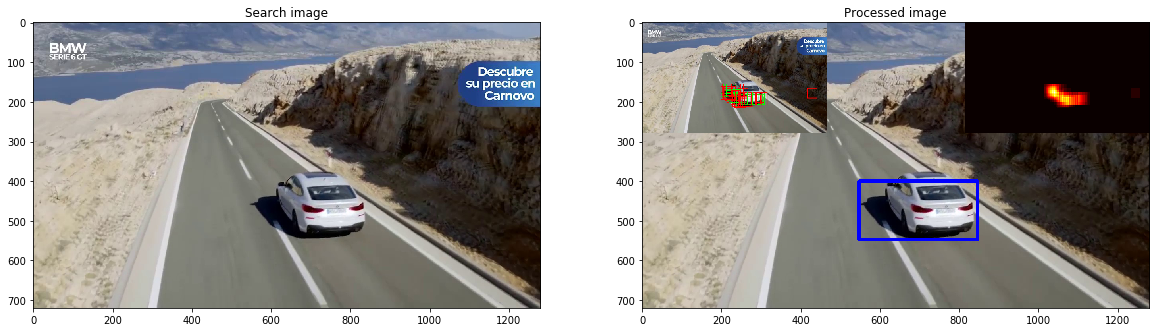

In [0]:
fig = plt.figure(figsize=(20,10))
#tst_images = glob.glob(myDrive+'test_images/*.jpg')
tst_images = glob.glob(myDrive+'test_images/frames/*.jpg')
tst_img = mpimg.imread(tst_images[50])
if tst_img.shape[2] == 4:
    tst_img = cv2.cvtColor(tst_img, cv2.COLOR_RGBA2RGB)

result, all_wins = vp_tst.process_img(tst_img, get_all_windows=True)

interre = draw_boxes(tst_img, all_wins)
fig.add_subplot(121)
plt.title("Search image")
plt.imshow(tst_img)

fig.add_subplot(122)
plt.title("Processed image")
plt.imshow(result)

## Testing the pipeline in a movie

In [0]:
import imageio
imageio.plugins.ffmpeg.download()
from moviepy.editor import VideoFileClip


In [0]:
def save_frames_from_video(video, save_dir, count):
    vidcap = cv2.VideoCapture(video)
    success,image = vidcap.read()
    index = 0
    success = True
    print("Writing frames...")
    while success and index<count:
        success, image = vidcap.read()
        cv2.imwrite(save_dir + "frame%d.jpg" % index, image)
        index += 1
    print("Wrote " + str(count) + " frames to " + save_dir)

In [0]:
save_frames_from_video(myDrive+"VideoTest.mp4", myDrive+"test_images/frames/", 200)

Writing frames...
Wrote 200 frames to /content/drive/My Drive/Colab Notebooks/Projecte final/vehicle-detection-master/test_images/frames/


In [0]:
challenge_output = myDrive+'Resultat_VideoTest.mp4'
clip3 = VideoFileClip(myDrive+'VideoTest.mp4')

regions = [
    Region(xstart=110, xstop=1280, ystart=400, ystop=560, cells_per_step=1, scales=[1,1.3]),
    Region(xstart=900, xstop=1280, ystart=400, ystop=560, cells_per_step=1, scales=[1.15]),
    Region(xstart=110, xstop=1280, ystart=500, ystop=680, cells_per_step=2, scales=[1.25])
]


processor = VideoProcessor(regions, X_scaler, hog_params, spatial_bin_params, color_hist_params, model, True, 1, True)
challenge_clip = clip3.fl_image(processor.process_img)
challenge_clip.write_videofile(challenge_output, audio=False)


[MoviePy] >>>> Building video /content/drive/My Drive/Colab Notebooks/Projecte final/vehicle-detection-master/Resultat_VideoTest.mp4
[MoviePy] Writing video /content/drive/My Drive/Colab Notebooks/Projecte final/vehicle-detection-master/Resultat_VideoTest.mp4



  2%|▏         | 1/60 [00:01<01:50,  1.87s/it]

153



  3%|▎         | 2/60 [00:03<01:48,  1.87s/it]

155



  5%|▌         | 3/60 [00:05<01:46,  1.87s/it]

165



  7%|▋         | 4/60 [00:07<01:44,  1.87s/it]

157



  8%|▊         | 5/60 [00:09<01:43,  1.88s/it]

141



 10%|█         | 6/60 [00:11<01:42,  1.89s/it]

160



 12%|█▏        | 7/60 [00:13<01:41,  1.91s/it]

165



 13%|█▎        | 8/60 [00:15<01:38,  1.90s/it]

131



 15%|█▌        | 9/60 [00:17<01:36,  1.89s/it]

101



 17%|█▋        | 10/60 [00:18<01:34,  1.89s/it]

110



 18%|█▊        | 11/60 [00:20<01:32,  1.89s/it]

91



 20%|██        | 12/60 [00:22<01:30,  1.89s/it]

83



 22%|██▏       | 13/60 [00:24<01:28,  1.89s/it]

73



 23%|██▎       | 14/60 [00:26<01:26,  1.88s/it]

67



 25%|██▌       | 15/60 [00:28<01:24,  1.88s/it]

87



 27%|██▋       | 16/60 [00:30<01:22,  1.88s/it]

72



 28%|██▊       | 17/60 [00:32<01:20,  1.88s/it]

85



 30%|███       | 18/60 [00:33<01:18,  1.88s/it]

73



 32%|███▏      | 19/60 [00:35<01:16,  1.87s/it]

76



 33%|███▎      | 20/60 [00:37<01:14,  1.87s/it]

69



 35%|███▌      | 21/60 [00:39<01:13,  1.88s/it]

65



 37%|███▋      | 22/60 [00:41<01:11,  1.87s/it]

63



 38%|███▊      | 23/60 [00:43<01:09,  1.87s/it]

67



 40%|████      | 24/60 [00:45<01:07,  1.87s/it]

76



 42%|████▏     | 25/60 [00:47<01:05,  1.88s/it]

80



 43%|████▎     | 26/60 [00:48<01:03,  1.88s/it]

75



 45%|████▌     | 27/60 [00:50<01:02,  1.88s/it]

61



 47%|████▋     | 28/60 [00:52<01:00,  1.88s/it]

73



 48%|████▊     | 29/60 [00:54<00:58,  1.88s/it]

81



 50%|█████     | 30/60 [00:56<00:56,  1.88s/it]

82



 52%|█████▏    | 31/60 [00:58<00:54,  1.88s/it]

75



 53%|█████▎    | 32/60 [01:00<00:52,  1.89s/it]

72



 55%|█████▌    | 33/60 [01:02<00:50,  1.88s/it]

67



 57%|█████▋    | 34/60 [01:03<00:49,  1.89s/it]

63



 58%|█████▊    | 35/60 [01:05<00:47,  1.88s/it]

57



 60%|██████    | 36/60 [01:07<00:45,  1.89s/it]

59



 62%|██████▏   | 37/60 [01:09<00:43,  1.91s/it]

60



 63%|██████▎   | 38/60 [01:11<00:42,  1.92s/it]

59




 67%|██████▋   | 40/60 [01:15<00:38,  1.93s/it]

60



 68%|██████▊   | 41/60 [01:17<00:36,  1.93s/it]

59



 70%|███████   | 42/60 [01:19<00:34,  1.91s/it]

61



 72%|███████▏  | 43/60 [01:21<00:32,  1.94s/it]

64



 73%|███████▎  | 44/60 [01:23<00:30,  1.92s/it]

53



 75%|███████▌  | 45/60 [01:25<00:28,  1.91s/it]

56



 77%|███████▋  | 46/60 [01:27<00:26,  1.90s/it]

60



 78%|███████▊  | 47/60 [01:28<00:24,  1.90s/it]

56



 80%|████████  | 48/60 [01:30<00:22,  1.90s/it]

58



 82%|████████▏ | 49/60 [01:32<00:20,  1.91s/it]

64



 83%|████████▎ | 50/60 [01:34<00:19,  1.91s/it]

60



 85%|████████▌ | 51/60 [01:36<00:17,  1.91s/it]

56



 87%|████████▋ | 52/60 [01:38<00:15,  1.92s/it]

57



 88%|████████▊ | 53/60 [01:40<00:13,  1.93s/it]

62



 90%|█████████ | 54/60 [01:42<00:11,  1.92s/it]

65



 92%|█████████▏| 55/60 [01:44<00:09,  1.92s/it]

76



 93%|█████████▎| 56/60 [01:46<00:07,  1.92s/it]

71



 95%|█████████▌| 57/60 [01:48<00:05,  1.92s/it]

74



 97%|█████████▋| 58/60 [01:50<00:03,  1.91s/it]

75



 98%|█████████▊| 59/60 [01:51<00:01,  1.91s/it]W0615 20:15:27.745696 140346418591616 warnings.py:99] /usr/local/lib/python3.6/dist-packages/moviepy/video/io/ffmpeg_reader.py:130: UserWarning: Warning: in file /content/drive/My Drive/Colab Notebooks/Projecte final/vehicle-detection-master/VideoTest.mp4, 2764800 bytes wanted but 0 bytes read,at frame 59/60, at time 1.97/2.00 sec. Using the last valid frame instead.
  UserWarning)



74



100%|██████████| 60/60 [01:53<00:00,  1.92s/it]


74
[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/drive/My Drive/Colab Notebooks/Projecte final/vehicle-detection-master/Resultat_VideoTest.mp4 

